# Project DNN

## Libraries

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from sklearn.datasets import fetch_openml

import scipy
import os

In [156]:
## we will use torch to accelerate the learning...

def np_to_torch(x): 
  #torch 
  if torch.cuda.is_available():  
    dev = "cuda:0" 
  else:  
    dev = "cpu"  

  device = torch.device(dev) 
  x = torch.from_numpy(x).to(device)

  return x.type(torch.FloatTensor)

## 1. Introduction

The objective of this project is to study deep neural networks for the classification of handwritten numbers. We will compare the performances, in terms of rate of good classifications, of a pre-trained network (using Deep Belief Networks) and of a randomly initialized network, as a function of the number of training data, the number of layers of the network and finally the number the number of neurons per layer.

## 2. Dataset Exploration

### 2.1 MNIST

In [136]:
def load_mnist():
  """
  This function import the mnist dataset which consists of 70,000 images of size 28*28.
  train size: 60,000
  test size: 10,000

  Each image is represented as a row of size 784 (flattend).
  Note that we will threshold to get binary images, and we will one-hot encode the labels to obtain y as a matrix of size n_samples*n_classes
  Reference: http://yann.lecun.com/exdb/mnist/
  It returns the training images, testing images and their respect labels.
  """
  mnist = fetch_openml('mnist_784')
  
  #Trunk the data
  n_train = 60000
  n_test = 10000

  #Define training and testing sets
  indices = np.arange(len(mnist.data))

  train_idx = np.arange(0,n_train)
  test_idx = np.arange(n_train+1,n_train+n_test)

  X_train, y_train = mnist.data[train_idx], mnist.target[train_idx].astype(int)
  X_test, y_test = mnist.data[test_idx], mnist.target[test_idx].astype(int)

  #Binarization
  threshold = 100
  X_train = np.array(X_train >= threshold, dtype=np.int8)
  X_test = np.array(X_test >= threshold, dtype=np.int8)

  #One-hot encoding
  n_values = np.max(y_train) + 1 #vector of size 10 to represent digits from 0 through 9

  y_train_o = np.eye(n_values)[y_train]
  y_test_o = np.eye(n_values)[y_test]
  
  return np_to_torch(X_train), np_to_torch(X_test), np_to_torch(y_train_o), np_to_torch(y_test_o)

In [139]:
#load MNIST dataset
X_train, X_test, y_train, y_test = load_mnist()

In [140]:
def plot_digit(x, y, dataset='mnist'):
  """
  x: 1D np.array -> one flattend digit
  y: one-hot encoded label
  dataset: type of dataset used. mnist or alphadigit
  """
  assert dataset in ['mnist', 'alphadigit']
  n = -1

  if dataset == 'mnist':
    n = 28
    label = np.argmax(y)
  else:
    n=20
    label = y
  
  plt.figure()
  if dataset == 'mnist' or y.isdigit():
    plt.title("digit {0}".format(label))
  else:
    plt.title("character {0}".format(label))
  plt.imshow(x.reshape(n,-1), cmap='gray')
  plt.axis('off')
  plt.show()

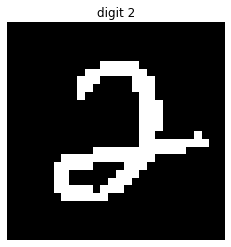

In [141]:
#visual example
sample_idx = 16
plot_digit(X_train[sample_idx], y_train[sample_idx])

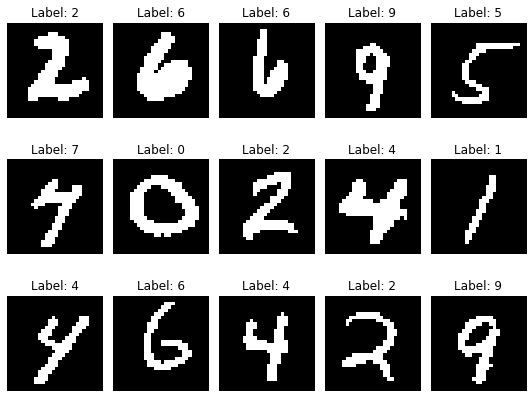

In [142]:
num_row = 3
num_col = 5
num = np.random.choice(np.arange(X_train.shape[0]), size=15)
images = X_train[num]
labels = np.argmax(y_train[num], axis=1)

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(len(num)):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i].reshape(28,28), cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
    ax.axis('off')
plt.tight_layout()
plt.show()

### 2.2 AlphaDigits

In [143]:
def get_char_ord(char='0'):
  """
  Get the order of character..
  '0-9' -> 0-9, 'A' -> 10, 'B' -> 11, ..., 'Z' -> 35
  """
  assert type(char) is str

  if char.isdigit():
    return int(char)
  else:
    return ord(char)-ord('A') + 10

In [144]:
def lire_alpha_digit(char='0'):
  """
  import the AlphaDigits dataset
  
  It consists of 20x16 Binary digits of "0" through "9" and capital "A" through "Z". 
  39 examples of each class.

  Only return the 39 examples corresponding the argument char.
  char: str "0" through "9" and capital "A" through "Z"


  reference: https://cs.nyu.edu/~roweis/data.html
  """

  file_name = "binaryalphadigs.mat"

  if not os.path.isfile(file_name): #check weither the file exist or not
    !wget https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat


  X = pd.DataFrame(scipy.io.loadmat(file_name)['dat'])   

  n_samples = len(X) * 39
  IMG = pd.DataFrame(np.zeros((n_samples, 20*16), dtype=np.int8))

  ligne = 0
  for i in range(X.shape[0]): 
      for j in range(X.shape[1]):
          IMG.iloc[ligne,:] = np.concatenate([X.iloc[i,j][k] for k in range(20)])
          ligne += 1

  indx_char = get_char_ord(char)
  
  return np_to_torch(np.array(IMG)[39*indx_char:39*(indx_char+1)])

In [145]:
#load alpha digit
char = 'B'
X = lire_alpha_digit(char)
X.shape

torch.Size([39, 320])

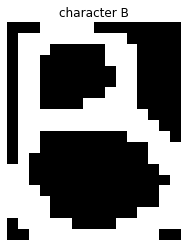

In [146]:
plot_digit(X[0], char, dataset='alphadigit')

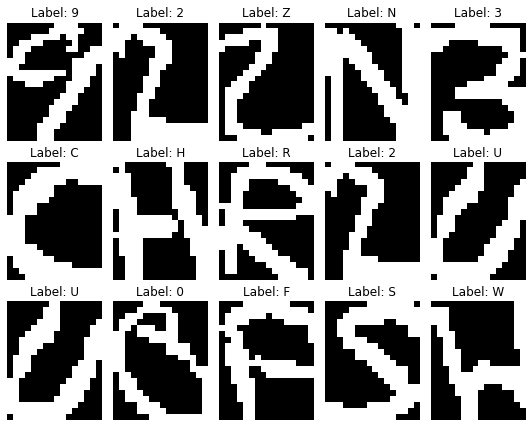

In [147]:
num_row = 3
num_col = 5
characters = ['{0}'.format(i) for i in range(10)] + list(map(chr, range(65, 91)))
indices = np.random.choice(np.arange(len(characters)), size=15)

images = []
labels = []

for char in indices:
  images.append(lire_alpha_digit(characters[char])[0])
  labels.append(characters[char])

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(len(num)):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i].reshape(20,16), cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3.1 `principal_RBM_alpha`

On veut apprendre les caractères de la base Binary AlphaDigits de votre choix via un RBM et de générer des caractères similaires à ceux appris.
La construction de ce programme nécessite les fonctions suivantes:

In [149]:
def lire_alpha_digit(char='0'):
  """
  import the AlphaDigits dataset
  
  It consists of 20x16 Binary digits of "0" through "9" and capital "A" through "Z". 
  39 examples of each class.

  Only return the 39 examples corresponding the argument char.
  char: str "0" through "9" and capital "A" through "Z"


  reference: https://cs.nyu.edu/~roweis/data.html
  """

  file_name = "binaryalphadigs.mat"

  if not os.path.isfile(file_name): #check weither the file exist or not
    !wget https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat


  X = pd.DataFrame(scipy.io.loadmat(file_name)['dat'])   

  n_samples = len(X) * 39
  IMG = pd.DataFrame(np.zeros((n_samples, 20*16), dtype=np.int8))

  ligne = 0
  for i in range(X.shape[0]): 
      for j in range(X.shape[1]):
          IMG.iloc[ligne,:] = np.concatenate([X.iloc[i,j][k] for k in range(20)])
          ligne += 1

  indx_char = get_char_ord(char)
  
  return np_to_torch(np.array(IMG)[39*indx_char:39*(indx_char+1)])

In [150]:
class RBM:
  def __init__(self, p, q, sigma):
    """
    sigma: ecart_type des poids
    """
    self.W = torch.normal(0, sigma, size=(p, q)).type(torch.FloatTensor)
    self.a = torch.zeros(1, p).type(torch.FloatTensor)
    self.b = torch.zeros(1, q).type(torch.FloatTensor)

In [151]:
def init_RBM(p, q, sigma=0.1):
  return RBM(p,q,sigma)

def sigmoid(x):
  return torch.sigmoid(x)

In [152]:
def entree_sortie_RBM(data, rbm):
  """
  data: matrice de taille mxp
  rbm: object du type RBM.
  """

  logits = torch.matmul(data, rbm.W) + rbm.b

  return sigmoid(logits)


def sortie_entree_RBM(data, rbm):
  """
  data: matrice de taille mxq
  rbm: object du type RBM.
  """

  logits = torch.matmul(data, rbm.W.T) + rbm.a

  return sigmoid(logits)

In [153]:
def train_RBM(rbm, epochs, lr, taille_batch, data):
  """
  faire le training du RBM en utilisant l'algorithm CD-1
  """

  n = data.shape[0]
  p, q = rbm.a.shape[1], rbm.b.shape[1]
  shuffled_index = np.arange(n)
  err_eqm = []

  for i in range(0, epochs):
    np.random.shuffle(shuffled_index)
    x = data[shuffled_index]
    for batch in range(0, n, taille_batch):
      data_batch = x[batch:min(batch+taille_batch, n), :]
      taille_batch = data_batch.shape[0]

      v0 = data_batch
      p_h_v0 = entree_sortie_RBM(v0, rbm)
      h_0 = (torch.rand(taille_batch, q) < p_h_v0).type(torch.FloatTensor)

      p_v_h0 = sortie_entree_RBM(h_0, rbm)
      v1 = (torch.rand(taille_batch, p) < p_v_h0).type(torch.FloatTensor)
      p_h_v1 = entree_sortie_RBM(v1, rbm)

      da = torch.sum(v0 - v1, dim=0)
      db = torch.sum(p_h_v0 - p_h_v1, dim=0)
      dW = torch.matmul(v0.T, p_h_v0) - torch.matmul(v1.T, p_h_v1)

      rbm.W += lr * dW/taille_batch
      rbm.a += lr * da/taille_batch
      rbm.b += lr * db/taille_batch

      #fin du batch
    h = entree_sortie_RBM(data, rbm)
    x_recovered = sortie_entree_RBM(h, rbm)
    err = torch.mean(torch.sum((data - x_recovered)**2, dim=1))
    err_eqm.append(err.detach())
  
  return rbm, err_eqm

In [154]:
def generer_image_RBM(rbm, nb_images, iter_gibbs, visualize = True):

  p, q = rbm.a.shape[1], rbm.b.shape[1]
  imgs = []
  for i in range(0, nb_images):
    v = (torch.rand(1,p)<0.5).type(torch.FloatTensor)
    for j in range(0, iter_gibbs):
      p_h = entree_sortie_RBM(v, rbm)
      h = (torch.rand(1,q)<p_h).type(torch.FloatTensor)
      p_v = sortie_entree_RBM(h, rbm)
      v = (torch.rand(1,p)<p_v).type(torch.FloatTensor)

    #fin generation
    imgs.append(1 * v.cpu().detach().numpy().reshape(20, 16))

    if visualize:
      plt.figure()
      plt.imshow(imgs[-1], cmap='gray') # AlphaDigits
      plt.title("Generated image after {0} iterations".format(iter_gibbs))
      plt.show()

  return np.array(imgs)

Faire un example:

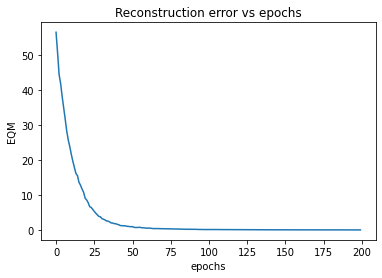

In [157]:
X_train = lire_alpha_digit('3')

p = X_train.shape[1]
q = 240

rbm = init_RBM(p, q)

n_epochs= 200
lr = 0.2
batch_size = 6

rbm, err_eqm = train_RBM(rbm, n_epochs, lr, batch_size, X_train)

plt.figure()
plt.plot(range(n_epochs), err_eqm)
plt.title('Reconstruction error vs epochs')
plt.xlabel('epochs')
plt.ylabel('EQM')
plt.show()

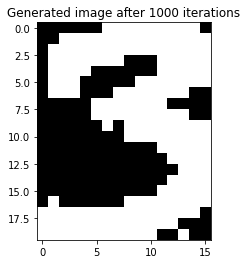

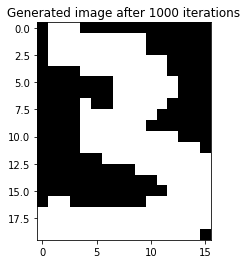

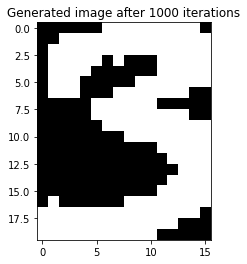

In [158]:
nb_images, nb_iterations = 3, 1000

x_generated_rbm = generer_image_RBM(rbm, nb_images, nb_iterations);

In [159]:
def plot_examples_alphadigits(X_train, x_generated, nb_iterations):
    """
    takes as input X_train (alphadigits stacked into rows) and x_generated a tensor of dimensiosn n_images x 20 x 16
    plots a comparaison between generated and training examples..
    """
    fig = plt.figure(figsize=(8, 8))
    n_generated = x_generated.shape[0]
    columns = min(n_generated, 4)
    rows = 2
    samples = np.random.choice(np.arange(X_train.shape[0]), size = columns, replace=False)

    plt.title("{0} examples generated with {1} Gibbs iterations".format(n_generated, nb_iterations))
    plt.axis('off')
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        if i > columns:
          plt.imshow(X_train[i].reshape(20,16), cmap='gray')
          plt.title('ex {0}'.format(samples[i-columns-1]), y=-0.2)
        else:
          plt.imshow(x_generated[i-1], cmap='gray')
          plt.title('generated ex {0}'.format(i), y=-0.2)
        
        plt.axis('off')
    
    
    plt.show()

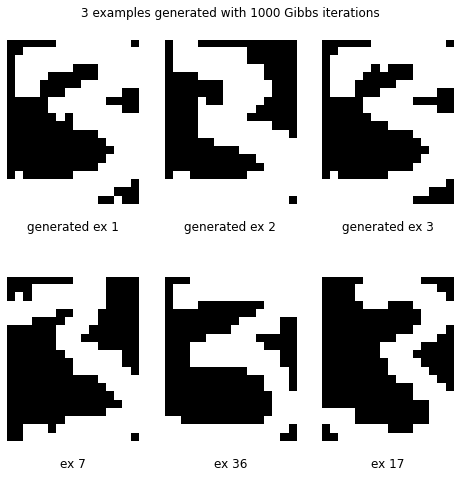

In [160]:
plot_examples_alphadigits(X_train, x_generated_rbm, nb_iterations)

### 3.1.1 RBM Analysis

In [163]:
def RBM_quant_analysis(char='3', q = 240, lr = 0.2, n_epochs = 200, batch_size = 6, visualize=True):
  """
  Plot the reconstractive error after training with the specified hyperparamters for a given character
  """

  X_train = lire_alpha_digit(char)
  p = X_train.shape[1]

  rbm = init_RBM(p, q)

  rbm, err_eqm = train_RBM(rbm, n_epochs, lr, batch_size, X_train)

  if visualize:
    plt.figure()
    plt.plot(range(n_epochs), err_eqm)
    plt.title('EQM: lr={0}, bs={1}, epochs={2}, q={3}, char={4}'.format(lr, batch_size, n_epochs, q, char))
    plt.xlabel('epochs')
    plt.ylabel('EQM')
    plt.show()

  return err_eqm

def RBM_qualt_analysis(rbm, X_train, nb_images = 3, nb_iterations = 1000):
  """
  Plot some examples after training with the specified hyperparamters for a given character
  """
  x_generated_rbm = generer_image_RBM(rbm, nb_images, nb_iterations, visualize=False)
  plot_examples_alphadigits(X_train, x_generated_rbm, nb_iterations)

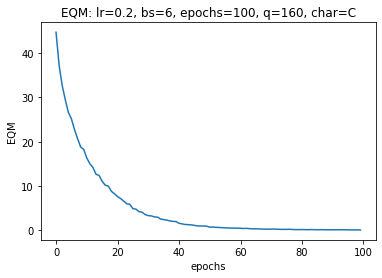

In [164]:
char = 'C'
q = 160
lr = 0.2
n_epochs= 100
batch_size = 6


RBM_quant_analysis(char, q, lr, n_epochs, batch_size);

In [165]:
char = 'C'
q = 160
lr = 0.2
n_epochs= 100
batch_size = 6
###
lrs = [1e-2, 1e-1, 1.5e-1, 2e-1, 2.5e-1, 3e-1, 5e-1]
batch_sizes = [1, 3, 6, 9, 18, 39]
n_epochss = [20, 40, 80, 100, 200]
qs = [260, 240, 220, 180, 160, 120, 80]
chars = ['A', 'S', 'X', '0', '8', '3']

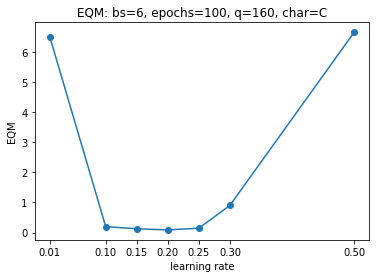

0.2

In [166]:
errs_lr = []

for lr in lrs:
  errs_lr.append(RBM_quant_analysis(char, q, lr, n_epochs, batch_size, False)[-1])

plt.figure()
plt.plot(lrs, errs_lr, marker='o')
plt.title('EQM: bs={0}, epochs={1}, q={2}, char={3}'.format(batch_size, n_epochs, q, char))
plt.xlabel('learning rate')
plt.xticks(lrs)
plt.ylabel('EQM')
plt.show()

best_lr = lrs[np.argmin(errs_lr)]
best_lr

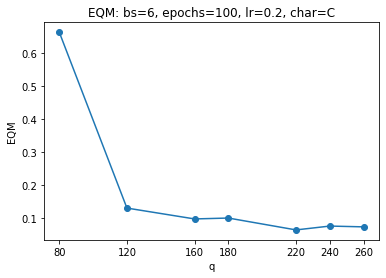

220

In [167]:
errs_q = []

for q in qs:
  errs_q.append(RBM_quant_analysis(char, q, best_lr, n_epochs, batch_size, False)[-1])

plt.figure()
plt.plot(qs, errs_q, marker='o')
plt.title('EQM: bs={0}, epochs={1}, lr={2}, char={3}'.format(batch_size, n_epochs, best_lr, char))
plt.xlabel('q')
plt.xticks(qs)
plt.ylabel('EQM')
plt.show()

best_q = qs[np.argmin(errs_q)]
best_q

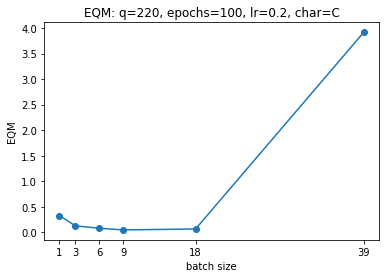

9

In [168]:
errs_bs = []

for batch_size in batch_sizes:
  errs_bs.append(RBM_quant_analysis(char, best_q, best_lr, n_epochs, batch_size, False)[-1])

plt.figure()
plt.plot(batch_sizes, errs_bs, marker='o')
plt.title('EQM: q={0}, epochs={1}, lr={2}, char={3}'.format(best_q, n_epochs, best_lr, char))
plt.xlabel('batch size')
plt.xticks(batch_sizes)
plt.ylabel('EQM')
plt.show()

best_bs = batch_sizes[np.argmin(errs_bs)]
best_bs

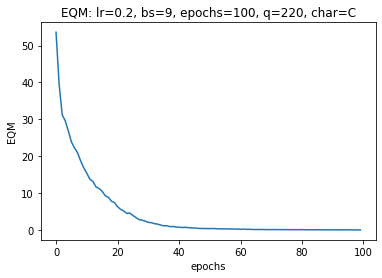

In [169]:
RBM_quant_analysis(char, best_q, best_lr, n_epochs, best_bs, True);

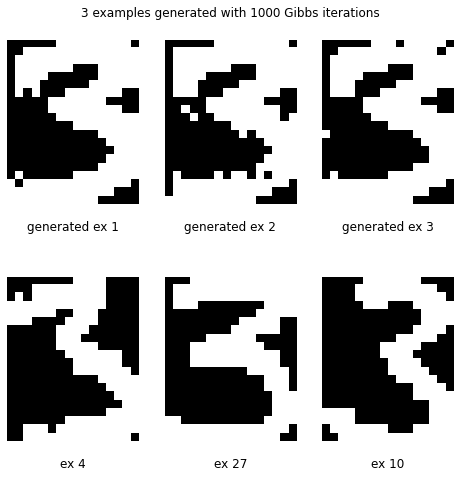

In [170]:
##qualitative analysis

char='3'
X_train = lire_alpha_digit(char)

rbm = init_RBM(p, best_q)
n_epochs= 100

rbm, err_eqm = train_RBM(rbm, n_epochs, best_lr, best_bs, X_train)

nb_iterations=1000
RBM_qualt_analysis(rbm, X_train, 3, nb_iterations)

## 3.2 `principal_DBN_alpha`



In [171]:
class DBN:
  def __init__(self, layers, hidden_units):
    """
    layers: minimum 1 layer -> RBM
    hidden_units: must be equal to layers + 1
    """

    assert(layers>=1)

    self.layers = [None] * layers
    self.hidden_units = hidden_units
    self.num_layers = layers

    for layer, layer_units in enumerate(hidden_units):
      self.layers[layer] = init_RBM(layer_units[0], layer_units[1])
    

In [172]:
def init_DNN(layers, hidden_units):
  return DBN(layers, hidden_units)

In [173]:
def pretrain_DNN(dbn, epochs, lr, taille_batch, data):

  err_layers = []
  x = data.clone()

  for i in range(dbn.num_layers):
    dbn.layers[i], err_eqm = train_RBM(dbn.layers[i], epochs, lr, taille_batch, x)
    err_layers.append(err_eqm)
    x = entree_sortie_RBM(x, dbn.layers[i])

  return dbn, err_layers

In [174]:
def generer_image_DBN(dbn, nb_images, iter_gibbs, visualize = True):

  p, q = dbn.layers[0].a.shape[1], dbn.layers[-1].b.shape[1]
  imgs = []

  for i in range(0, nb_images):
    v = (torch.rand(1,dbn.layers[-1].W.shape[0])<0.5).type(torch.FloatTensor)

    for j in range(0, iter_gibbs):
      p_h = entree_sortie_RBM(v, dbn.layers[-1])
      h = (torch.rand(p_h.shape[0],p_h.shape[1])<p_h).type(torch.FloatTensor)
      p_v = sortie_entree_RBM(h, dbn.layers[-1])
      v = (torch.rand(p_v.shape[0],p_v.shape[1])<p_v).type(torch.FloatTensor)

    for l in range(dbn.num_layers-2, -1, -1):
      proba = sortie_entree_RBM(v, dbn.layers[l])
      v = (torch.rand(proba.shape[0], proba.shape[1])<proba).type(torch.FloatTensor)


    #fin generation
    imgs.append(1 * v.cpu().detach().numpy().reshape(20, 16))
    if visualize:
      plt.figure()
      plt.imshow(imgs[-1], cmap='gray') # AlphaDigits
      plt.title("Generated image after {0} iterations".format(iter_gibbs))
      plt.show()

  return np.array(imgs)

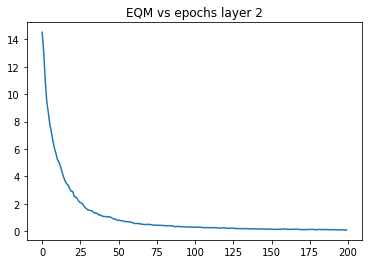

In [176]:
X_train = lire_alpha_digit('C')

p = X_train.shape[1]
q = 240
num_layers = 3 

dbn = init_DNN(num_layers, [(p, p//2), (p//2, p//4), (p//4,p//6)])

n_epochs= 200
lr = 0.2
batch_size = 6

dbn, err_eqm = pretrain_DNN(dbn, n_epochs, lr, batch_size, X_train)

plt.figure()
layer = 2
plt.plot(range(n_epochs), err_eqm[layer])
plt.title('EQM vs epochs layer {0}'.format(layer))
plt.show()

In [177]:
nb_generated, nb_iterations = 3, 1000

x_generated_dbn = generer_image_DBN(dbn, nb_generated, nb_iterations, False);

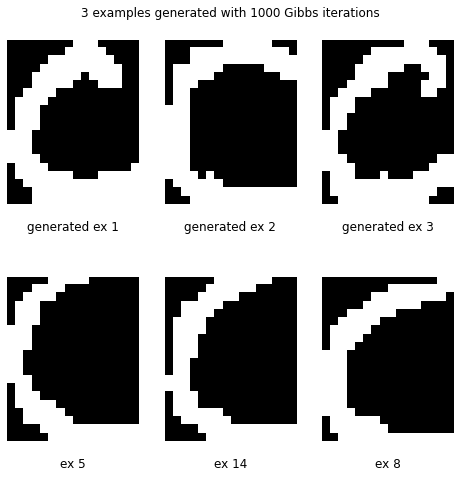

In [178]:
plot_examples_alphadigits(X_train, x_generated_dbn, nb_iterations)

### 3.2.1 DBN Analysis

In [181]:
def DBN_quant_analysis(char='3', num_layers = 3, neurons = None, lr = 0.2, n_epochs = 200, batch_size = 6, layer = 0, visualize=True):
  """
  Plot the reconstractive error after training with the specified hyperparamters for a given character
  """
  
  X_train = lire_alpha_digit(char)
  p = X_train.shape[1]
  if neurons is None:
    neurons = [(p, p//2), (p//2, p//4), (p//4,p//6)]

  assert num_layers == len(neurons)

  dbn = init_DNN(num_layers, neurons)

  dbn, err_eqm = pretrain_DNN(dbn, n_epochs, lr, batch_size, X_train)

  if visualize:
    plt.figure()
    plt.plot(range(n_epochs), err_eqm[layer])
    plt.title('EQM: lr={0}, bs={1}, epochs={2}, neruons={3}, char={4}, layer={5}'.format(lr, batch_size, n_epochs, "/".join([str(n[1]) for n in neurons]), char, layer))
    plt.xlabel('epochs')
    plt.ylabel('EQM')
    plt.show()

  return err_eqm

def DBN_qualt_analysis(dbn, X_train, nb_images = 3, nb_iterations = 1000):
  """
  Plot some examples after training with the specified hyperparamters for a given character
  """
  x_generated_dbn = generer_image_DBN(dbn, nb_images, nb_iterations, visualize=False)
  plot_examples_alphadigits(X_train, x_generated_dbn, nb_iterations)

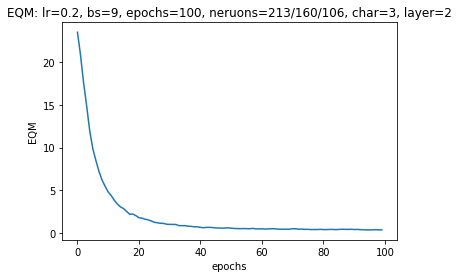

In [182]:
char = '3'

X_train = lire_alpha_digit(char)
p = X_train.shape[1]
num_layers = 3 
n_epochs= 100
neurons = [(p, 2*p//3), (2*p//3, p//2), (p//2,p//3)]

DBN_quant_analysis(char, num_layers, neurons, best_lr, n_epochs, best_bs, layer=2);

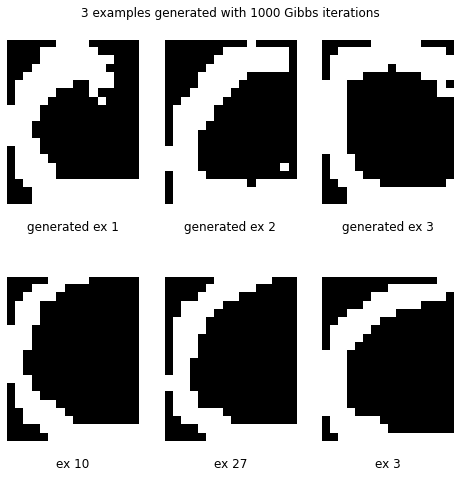

In [183]:
char = 'C'
X_train = lire_alpha_digit(char)
p = X_train.shape[1]
num_layers = 3 
neurons = [(p, 2*p//3), (2*p//3, p//2), (p//2,p//3)]

dbn = init_DNN(num_layers, neurons)
dbn, err_eqm = pretrain_DNN(dbn, n_epochs, best_lr, best_bs, X_train)

nb_images, nb_iterations = 3, 1000
DBN_qualt_analysis(dbn, X_train, nb_images, nb_iterations)

## 3.3 `principal_DNN_MNIST`

In [184]:
def calcul_softmax(rbm, data):
    x = torch.matmul(data, rbm.W) + rbm.b
    return F.softmax(x, dim=1)

In [185]:
def entree_sortie_reseau(dnn, X):
    sorties_couches = []
    sorties_couches.append(entree_sortie_RBM(X, dnn.layers[0]))
    for i in range(1, dnn.num_layers-1):
        sorties_couches.append(entree_sortie_RBM(sorties_couches[-1], dnn.layers[i]))
    sorties_couches.append(calcul_softmax(dnn.layers[-1], sorties_couches[-1]))
    return sorties_couches

In [186]:
def copy_dnn(dnn):
    new_dnn = init_DNN(dnn.num_layers, [dnn.layers[i].W.shape for i in range(dnn.num_layers)])
    for i in range(dnn.num_layers):
        new_dnn.layers[i].a = dnn.layers[i].a.clone()
        new_dnn.layers[i].b = dnn.layers[i].b.clone()
        new_dnn.layers[i].W = dnn.layers[i].W.clone()
    return new_dnn

In [211]:
import time

def retropropagation(dnn, X_train, y_train, nb_iter, lr, batch_size, pre_trained, visualize = True, verbose = 0):
    
    start = time.time()
    cross_entropy = []
    for i in range(nb_iter):
        indices = np.arange(0,X_train.shape[0],1)
        np.random.shuffle(indices)
        for j in range(0, X_train.shape[0], batch_size):
            new_dnn = copy_dnn(dnn)
            batch_ind = indices[j:min(j+batch_size, X_train.shape[0])]
            data = X_train[batch_ind,:]
            sorties_couches = entree_sortie_reseau(dnn, data)
            
            ## début dernière couche
            matrice_c = sorties_couches[-1] - y_train[batch_ind]
            der_w = torch.matmul(sorties_couches[dnn.num_layers-2].T, matrice_c)/data.shape[0]
            der_b = torch.sum(matrice_c, dim = 0)/data.shape[0]
            new_dnn.layers[-1].W -= lr*der_w #/batch
            new_dnn.layers[-1].b -= lr*der_b
            ## fin dernière couche
            
            for couche in range(dnn.num_layers-2, -1, -1):
                if couche == 0:
                    inpute = data
                else:
                    inpute = sorties_couches[couche-1]

                h_mult = sorties_couches[couche]*(1-sorties_couches[couche])
                matrice_c = torch.matmul(matrice_c, dnn.layers[couche+1].W.T)*h_mult                
                der_w = torch.matmul(inpute.T, matrice_c)/data.shape[0]
                der_b = torch.sum(matrice_c, dim=0)/data.shape[0]
                new_dnn.layers[couche].W -= lr*der_w
                new_dnn.layers[couche].b -= lr*der_b
            dnn = copy_dnn(new_dnn)
        sorties_couches = entree_sortie_reseau(dnn, X_train)
        classif = -torch.log10(sorties_couches[-1])[y_train==1]
        erreur = torch.mean(classif, dim=0)
        cross_entropy.append(erreur)

        if verbose != 0 and i%verbose == 0:
          end = time.time()
          print("%i/%i epoch: loss %f time %f s"%(i+1,nb_iter,cross_entropy[-1],(end-start)))
          start = time.time()

    if visualize:
      f = plt.figure(figsize=(10, 7))
      plt.plot(range(nb_iter), cross_entropy)
      plt.legend(['Entropie croisée'])
      plt.title("Évolution de l'entropie croisée au cours des iterations")
      plt.xlabel("nombre d'itérations")
      plt.ylabel('entropie croisée')
      f.savefig('retropropagation_{}.png'.format(pre_trained))
      return dnn
    
    else:
      return dnn, cross_entropy[-1]

In [204]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def accuracy_score(y_test, y_pred):
    result = (y_test != y_pred)
    return "Accuracy : {}%".format(round((1 - (result.sum()//2)/y_test.shape[0])*100*100)/100)


def matrice_de_confusion(y_test, y_pred, erreur, pre_trained):
    y_t = []
    y_p = []
    for i in range(y_test.shape[0]):
        for j in range(y_test.shape[1]):
            if y_test[i,j] == 1:
                y_t.append(j)
            if y_pred[i,j] == 1:
                y_p.append(j)
    df_cm = pd.DataFrame(confusion_matrix(y_t, y_p), index = range(10), columns = range(10))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.title("MATRICE DE CONFUSION {} \n {}\n Entropie croisée : {}".format(pre_trained, accuracy_score(y_test, y_pred), round(erreur*100)/100))
    plt.savefig('confusion_mat_{}.png'.format(pre_trained))



def test_DNN(dnn, X_test, y_test, pre_trained, visualize = True):
    y_pred = entree_sortie_reseau(dnn, X_test)[-1]
    classif = -torch.log10(y_pred)[y_test==1]
    erreur = torch.mean(classif, dim=0).cpu().detach().numpy()
    for i in range(y_pred.shape[0]):
        for j in range(y_pred.shape[1]):
            if y_pred[i,j] == max(y_pred[i,:]):
                y_pred[i,j] = 1
            else:
                y_pred[i,j] = 0
    acc_score = accuracy_score(y_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
    print(acc_score)
    if visualize:
      matrice_de_confusion(y_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), erreur, pre_trained)

    return float(acc_score.split(':')[-1].split('%')[0])/100, erreur

## 5. MNIST Study

### 5.1 Etude à réaliser (MNIST)

In [196]:
X, X_test, y, y_test = load_mnist()
p = X.shape[1]
q = 10

neurons = [(p, 300), (300, 300), (300, 300), (300, q)]
num_layers = len(neurons)

n_epochs= 100
lr = 0.15
batch_size = 100

training_samples = X.shape[0]//2
X_train, y_train = X[:training_samples, :], y[:training_samples]

In [197]:
dnn = init_DNN(num_layers, neurons)

In [198]:
dnn, _ = pretrain_DNN(dnn, n_epochs, lr, batch_size, X_train)

1/100 epoch: loss 0.314887 time 4.177451 s
11/100 epoch: loss 0.075836 time 41.976812 s
21/100 epoch: loss 0.049371 time 41.625487 s
31/100 epoch: loss 0.035014 time 41.193022 s
41/100 epoch: loss 0.026041 time 41.288471 s
51/100 epoch: loss 0.019785 time 41.121292 s
61/100 epoch: loss 0.015259 time 41.014810 s
71/100 epoch: loss 0.012125 time 41.588529 s
81/100 epoch: loss 0.009614 time 41.769358 s
91/100 epoch: loss 0.007825 time 41.217758 s


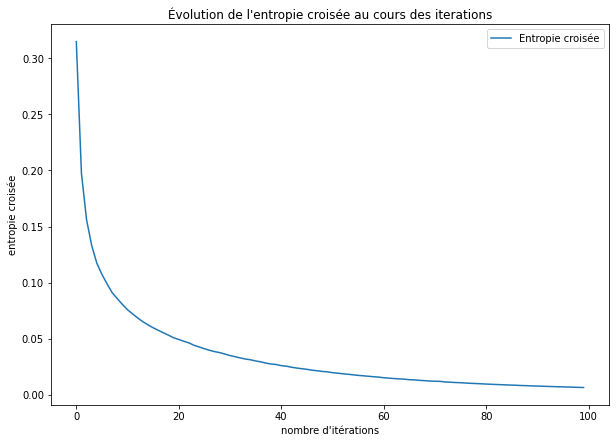

In [202]:
dnn = retropropagation(dnn, X_train, y_train, n_epochs, lr, batch_size, "normal", verbose=10)

Accuracy : 96.8%


(0.968, array(0.0463236, dtype=float32))

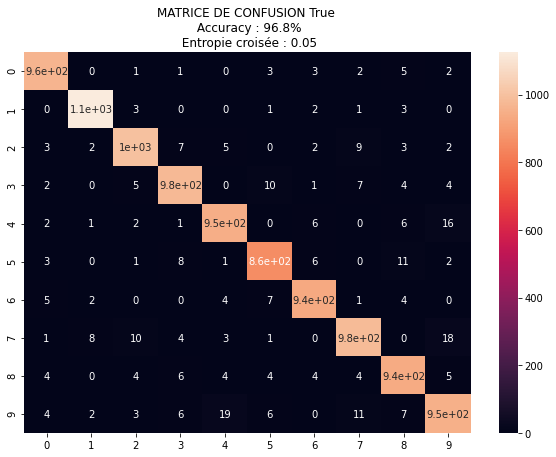

In [205]:
test_DNN(dnn, X_test, y_test, True)

### 5.2 Analyse

In [240]:
X, X_test, y, y_test = load_mnist()

#### 5.2.1 En fonction du **nombre de couches**

In [241]:
##fixed parameteres

p = X.shape[1]
q = 10

hidden_units = 200
n_epochs_rbm = 30
n_epochs_retro = 20
lr = 0.15
batch_size = 100

training_samples = X.shape[0]//2
X_train, y_train = X[:training_samples, :], y[:training_samples]

In [242]:
##variable parameteres

test_layers = 5

first_layer = [(p, hidden_units)]
last_layer = [(hidden_units, q)]
neurons_v = [[(p, hidden_units), (hidden_units, q)]]

for i in range(1, test_layers):
  neurons_v += [first_layer + [(hidden_units,hidden_units)]*i + last_layer]

In [243]:
neurons_v

[[(784, 200), (200, 10)],
 [(784, 200), (200, 200), (200, 10)],
 [(784, 200), (200, 200), (200, 200), (200, 10)],
 [(784, 200), (200, 200), (200, 200), (200, 200), (200, 10)],
 [(784, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 10)]]

In [244]:
##track of error the tests
acc_pre, crossentropy_pre = [], []
acc_norm, crossentropy_norm = [], []

In [245]:
for neurons in neurons_v:
  num_layers = len(neurons)

  #initialize identical networks
  dnn_pre = init_DNN(num_layers, neurons)
  dnn_norm = copy_dnn(dnn_pre)

  #pre-entrain one and fine-tune
  dnn_pre, _ = pretrain_DNN(dnn_pre, n_epochs_rbm, lr, batch_size, X_train)
  dnn_pre, _ = retropropagation(dnn_pre, X_train, y_train, n_epochs_retro, lr, batch_size, "pre-trained", False)
  print("Pre-trained with {0} hidden layers".format(num_layers-1))
  test_scores = test_DNN(dnn_pre, X_test, y_test, "", False)
  acc_pre.append(test_scores[0])
  crossentropy_pre.append(test_scores[1])

  print("\n")

  #use the initial network without pre-entraining
  dnn_norm, _ = retropropagation(dnn_norm, X_train, y_train, n_epochs_retro, lr, batch_size, "normal", False)
  print("Normal with {0} hidden layers".format(num_layers-1))
  test_scores = test_DNN(dnn_norm, X_test, y_test, "", False)
  acc_norm.append(test_scores[0])
  crossentropy_norm.append(test_scores[1])

  print("-----------------")

Pre-trained with 1 hidden layers
Accuracy : 92.73%


Normal with 1 hidden layers
Accuracy : 94.06%
-----------------
Pre-trained with 2 hidden layers
Accuracy : 94.7%


Normal with 2 hidden layers
Accuracy : 94.11%
-----------------
Pre-trained with 3 hidden layers
Accuracy : 95.52%


Normal with 3 hidden layers
Accuracy : 94.36%
-----------------
Pre-trained with 4 hidden layers
Accuracy : 96.24%


Normal with 4 hidden layers
Accuracy : 94.05%
-----------------
Pre-trained with 5 hidden layers
Accuracy : 96.13%


Normal with 5 hidden layers
Accuracy : 92.92%
-----------------


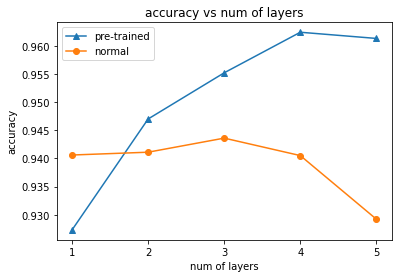

In [246]:
##visualization
variables = np.arange(1, test_layers+1)

plt.figure()
plt.plot(variables, acc_pre, marker='^', label='pre-trained')
plt.plot(variables, acc_norm, marker='o', label='normal')
plt.xticks(variables)
plt.xlabel('num of layers')
plt.ylabel('accuracy')
plt.title('accuracy vs num of layers')
plt.legend()
plt.savefig("acc_vs_numlayers.png")
plt.show()

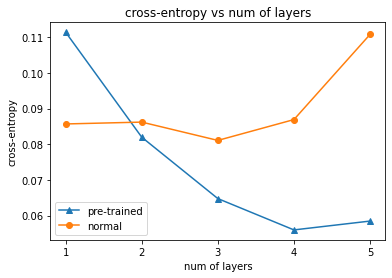

In [247]:
##visualization
variables = np.arange(1, test_layers+1)

plt.figure()
plt.plot(variables, crossentropy_pre, marker='^', label='pre-trained')
plt.plot(variables, crossentropy_norm, marker='o', label='normal')
plt.xticks(variables)
plt.xlabel('num of layers')
plt.ylabel('cross-entropy')
plt.title('cross-entropy vs num of layers')
plt.legend()
plt.savefig("crosse_vs_numlayers.png")
plt.show()

#### 5.2.2 En fonction du **nombre de nombre de neurones par couches**

In [273]:
##fixed parameteres

p = X.shape[1]
q = 10

num_layers = 3 # 2 hidden layers
n_epochs_rbm = 20
n_epochs_retro = 20
lr = 0.15
batch_size = 100

training_samples = X.shape[0]//2
X_train, y_train = X[:training_samples, :], y[:training_samples]

In [274]:
##variable parameteres

hidden_units_v = [100, 200, 300, 500, 1000]
neurons_v = []
for hidden_units in hidden_units_v:
  neurons_v.append([(p, hidden_units), (hidden_units,hidden_units), (hidden_units, q)])

In [275]:
neurons_v

[[(784, 100), (100, 100), (100, 10)],
 [(784, 200), (200, 200), (200, 10)],
 [(784, 300), (300, 300), (300, 10)],
 [(784, 500), (500, 500), (500, 10)],
 [(784, 1000), (1000, 1000), (1000, 10)]]

In [276]:
##track of error the tests
acc2_pre, crossentropy2_pre = [], []
acc2_norm, crossentropy2_norm = [], []

In [277]:
for idx, neurons in enumerate(neurons_v):
  
  #initialize identical networks
  dnn_pre = init_DNN(num_layers, neurons)
  dnn_norm = copy_dnn(dnn_pre)

  #pre-entrain one and fine-tune
  dnn_pre, _ = pretrain_DNN(dnn_pre, n_epochs_rbm, lr, batch_size, X_train)
  dnn_pre, _ = retropropagation(dnn_pre, X_train, y_train, n_epochs_retro, lr, batch_size, "pre-trained", False)
  print("Pre-trained with {0} hidden units".format(hidden_units_v[idx]))
  test_scores = test_DNN(dnn_pre, X_test, y_test, "", False)
  acc2_pre.append(test_scores[0])
  crossentropy2_pre.append(test_scores[1])

  print("\n")

  #use the initial network without pre-entraining
  dnn_norm, _ = retropropagation(dnn_norm, X_train, y_train, n_epochs_retro, lr, batch_size, "normal", False)
  print("Normal with {0} hidden units".format(hidden_units_v[idx]))
  test_scores = test_DNN(dnn_norm, X_test, y_test, "", False)
  acc2_norm.append(test_scores[0])
  crossentropy2_norm.append(test_scores[1])

  print("-----------------")

Pre-trained with 100 hidden units
Accuracy : 93.01%


Normal with 100 hidden units
Accuracy : 94.38%
-----------------
Pre-trained with 200 hidden units
Accuracy : 94.15%


Normal with 200 hidden units
Accuracy : 94.05%
-----------------
Pre-trained with 300 hidden units
Accuracy : 94.62%


Normal with 300 hidden units
Accuracy : 93.81%
-----------------
Pre-trained with 500 hidden units
Accuracy : 94.35%


Normal with 500 hidden units
Accuracy : 94.09%
-----------------
Pre-trained with 1000 hidden units
Accuracy : 94.08%


Normal with 1000 hidden units
Accuracy : 94.59%
-----------------


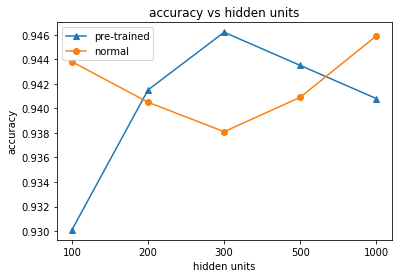

In [278]:
##visualization
variables = np.arange(1, len(hidden_units_v)+1)

plt.figure()
plt.plot(variables, acc2_pre, marker='^', label='pre-trained')
plt.plot(variables, acc2_norm, marker='o', label='normal')
plt.xticks(variables, hidden_units_v)
plt.xlabel('hidden units')
plt.ylabel('accuracy')
plt.title('accuracy vs hidden units')
plt.legend()
plt.savefig("acc_vs_hiddenunits.png")
plt.show()

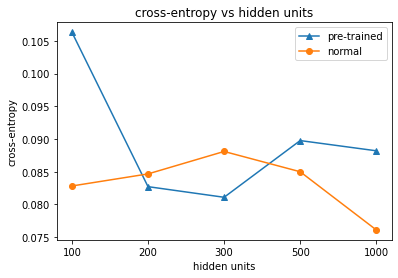

In [279]:
##visualization
variables = np.arange(1, len(hidden_units_v)+1)

plt.figure()
plt.plot(variables, crossentropy2_pre, marker='^', label='pre-trained')
plt.plot(variables, crossentropy2_norm, marker='o', label='normal')
plt.xticks(variables, hidden_units_v)
plt.xlabel('hidden units')
plt.ylabel('cross-entropy')
plt.title('cross-entropy vs hidden units')
plt.legend()
plt.savefig("crosse_vs_hiddenunits.png")
plt.show()

#### 5.2.3 En fonction du **nombre de données train**

In [255]:
##fixed parameteres
p = X.shape[1]
q = 10

hidden_units = 200
num_layers = 3 # 2 hidden layers
neurons = [(p, hidden_units), (hidden_units, hidden_units), (hidden_units, q)]
n_epochs_rbm = 20
n_epochs_retro = 20
lr = 0.15
batch_size = 100

In [256]:
##variable parameteres
training_samples_v = [1000, 3000, 7000, 10000, 30000, 60000]

In [257]:
##track of error the tests
acc3_pre, crossentropy3_pre = [], []
acc3_norm, crossentropy3_norm = [], []

In [258]:
for training_samples in training_samples_v:
  X_train, y_train = X[:training_samples, :], y[:training_samples]

  #initialize identical networks
  dnn_pre = init_DNN(num_layers, neurons)
  dnn_norm = copy_dnn(dnn_pre)

  #pre-entrain one and fine-tune
  dnn_pre, _ = pretrain_DNN(dnn_pre, n_epochs_rbm, lr, batch_size, X_train)
  dnn_pre, _ = retropropagation(dnn_pre, X_train, y_train, n_epochs_retro, lr, batch_size, "pre-trained", False)
  print("Pre-trained with {0} training samples".format(training_samples))
  test_scores = test_DNN(dnn_pre, X_test, y_test, "", False)
  acc3_pre.append(test_scores[0])
  crossentropy3_pre.append(test_scores[1])

  print("\n")

  #use the initial network without pre-entraining
  dnn_norm, _ = retropropagation(dnn_norm, X_train, y_train, n_epochs_retro, lr, batch_size, "normal", False)
  print("Normal with {0} training samples".format(training_samples))
  test_scores = test_DNN(dnn_norm, X_test, y_test, "", False)
  acc3_norm.append(test_scores[0])
  crossentropy3_norm.append(test_scores[1])

  print("-----------------")

Pre-trained with 1000 training samples
Accuracy : 75.26%


Normal with 1000 training samples
Accuracy : 72.44%
-----------------
Pre-trained with 3000 training samples
Accuracy : 87.21%


Normal with 3000 training samples
Accuracy : 86.65%
-----------------
Pre-trained with 7000 training samples
Accuracy : 90.47%


Normal with 7000 training samples
Accuracy : 90.11%
-----------------
Pre-trained with 10000 training samples
Accuracy : 91.35%


Normal with 10000 training samples
Accuracy : 91.02%
-----------------
Pre-trained with 30000 training samples
Accuracy : 94.45%


Normal with 30000 training samples
Accuracy : 94.27%
-----------------
Pre-trained with 60000 training samples
Accuracy : 96.05%


Normal with 60000 training samples
Accuracy : 96.13%
-----------------


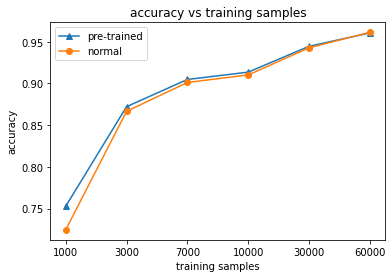

In [259]:
##visualization
variables = np.arange(1, len(training_samples_v)+1)

plt.figure()
plt.plot(variables, acc3_pre, marker='^', label='pre-trained')
plt.plot(variables, acc3_norm, marker='o', label='normal')
plt.xticks(variables, training_samples_v)
plt.xlabel('training samples')
plt.ylabel('accuracy')
plt.title('accuracy vs training samples')
plt.legend()
plt.savefig("acc_vs_trsamples.png")
plt.show()

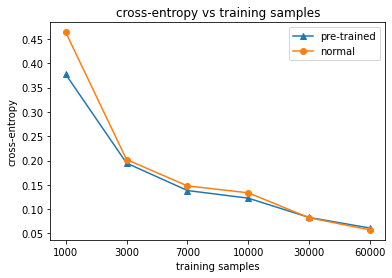

In [260]:
##visualization
variables = np.arange(1, len(training_samples_v)+1)

plt.figure()
plt.plot(variables, crossentropy3_pre, marker='^', label='pre-trained')
plt.plot(variables, crossentropy3_norm, marker='o', label='normal')
plt.xticks(variables, training_samples_v)
plt.xlabel('training samples')
plt.ylabel('cross-entropy')
plt.title('cross-entropy vs training samples')
plt.legend()
plt.savefig("crosse_vs_trsamples.png")
plt.show()

### 5.3 Classification

In [206]:
X, X_test, y, y_test = load_mnist()

In [233]:
p = X.shape[1]
q = 10

neurons = [(p, 200), (200, 200), (200, 200), (200,q)]
num_layers = len(neurons)
n_epochs_rbm = 40
n_epochs_retro = 60
lr = 0.2
batch_size = 100

training_samples = X.shape[0]
X_train, y_train = X[:training_samples, :], y[:training_samples]

In [234]:
dnn = init_DNN(num_layers, neurons)
dnn_normal = copy_dnn(dnn)

In [235]:
dnn, _ = pretrain_DNN(dnn, n_epochs_rbm, lr, batch_size, X_train)

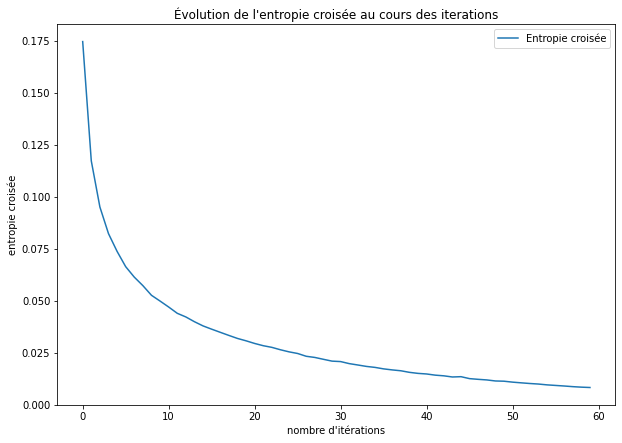

In [236]:
dnn = retropropagation(dnn, X_train, y_train, n_epochs_retro, lr, batch_size, "pre-trained")

Accuracy : 97.57%


(0.9756999999999999, array(0.03674586, dtype=float32))

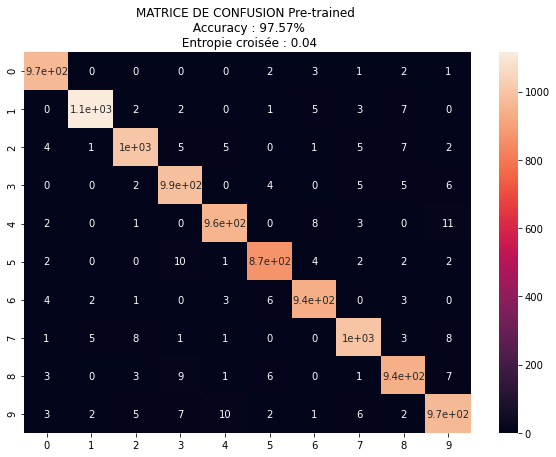

In [237]:
test_DNN(dnn, X_test, y_test, "Pre-trained")

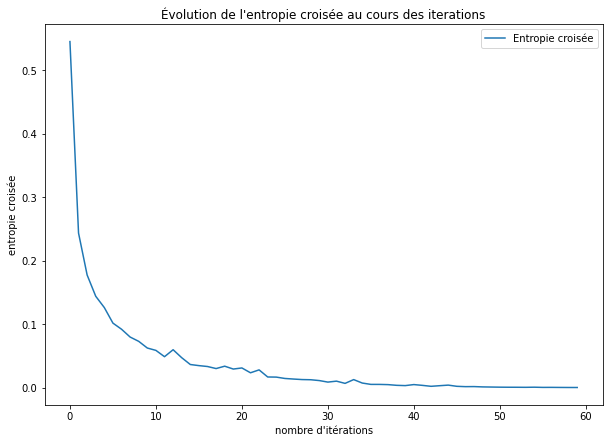

In [238]:
dnn_normal = retropropagation(dnn_normal, X_train, y_train, n_epochs_retro, lr, batch_size, "normal")

Accuracy : 97.39%


(0.9739, array(0.04999633, dtype=float32))

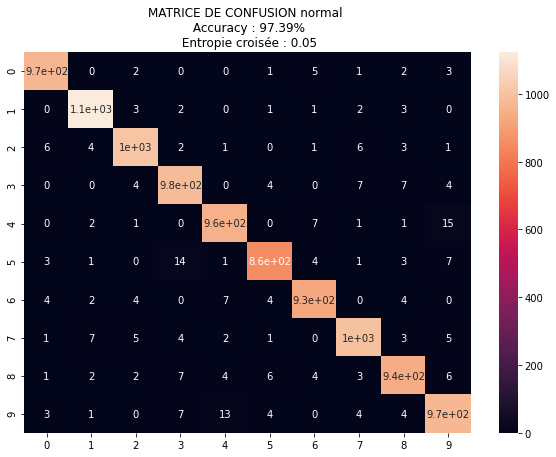

In [239]:
test_DNN(dnn_normal, X_test, y_test, "normal")